# ASL Demo WebCam



In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

## Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Webcam Setup
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [3]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # save image
  cv2.imwrite(filename, img)

  return filename

## Load Model & Resize

In [4]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import tensorflow as tf
import pathlib
import cv2
import numpy as np
from string import ascii_lowercase as alc
from google.colab.patches import cv2_imshow
import os

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# define letter map
ASL_map = {}
for i in range(0, 26):
    ASL_map[i] = alc[i]
ASL_map[26] = 'del'
ASL_map[27] = 'nothing'
ASL_map[28] = 'space'

In [7]:
def prepare(filepath):
    image = cv2.imread(filepath)
    image = cv2.resize(image, (224,224))
   # image.reshape(-1, 224, 224, 3)
    cv2_imshow(image)
    image = image[np.newaxis, :,  :, :]
    return image.astype('float32')/255.0

In [8]:
def get_top_x(prediction, x):
  result = sorted(range(len(prediction[0])), key=lambda i: prediction[0][i])
  result.reverse()
  print('The predicted results:')

  for i in result[:x]:
    print("Letter-{}, {}%".format(ASL_map[i],prediction[0][i]*100))
  print()
  print()

In [9]:
model_Efficientnet = load_model('/content/gdrive/MyDrive/CMPE255_ASL_PROJECT/Efficientnet_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})
model_Efficientnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Efficientnet_b0 (KerasLayer  (None, 1000)             5330564   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 Output_layer (Dense)        (None, 29)                29029     
                                                                 
Total params: 5,359,593
Trainable params: 29,029
Non-trainable params: 5,330,564
_________________________________________________________________


## Connect Cam and predict

Your testing letter: b


<IPython.core.display.Javascript object>

(480, 640)
Saved to Letter_b.jpg


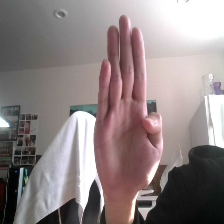

1/1 [==============================] - 8s 8s/step
The predicted results:
Letter-i, 48.90267848968506%
Letter-b, 26.703572273254395%
Letter-k, 23.798467218875885%




KeyboardInterrupt: ignored

In [10]:
try:
  while True:
    currentLetter=input("Your testing letter: ")
    filename = take_photo('Letter_{}.jpg'.format(currentLetter))
    print('Saved to {}'.format(filename))
    time.sleep(5)
    get_top_x(model_Efficientnet.predict(prepare('/content/{}'.format(filename))), 3)
    
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

reference: https://www.youtube.com/watch?v=YjWh7QvVH60